In [1]:
import numpy as np

In [2]:
pwd

'C:\\Python Files\\AluminaConcEstimator\\NoteBooks'

In [3]:
import sys
sys.path.append('../')

In [4]:
from Refactor.Properties import ValidProperty, CellProperties
from Refactor.Model import VariableVector, ControlMatrix, clone_vector
from Refactor.CellVoltage import VIcell
from numpy.linalg import inv
from scipy.linalg import cholesky, LinAlgError

In [5]:
# Need to define the cell first
bbcell = CellProperties()

In [6]:
# need to extract gamma to define the control matrices - it has dependency on a valid CE
gamma, validg = bbcell.gamma
print(gamma, validg)

1.664337575188073e-05 True


In [7]:
# Create initial State Vector Variables
x0 = VariableVector(cAl2O3=3.5, deltag=9.0, ACD=2.9193, deltaI=0.0)
x0.dictionary

{'cAl2O3': 0, 'deltag': 1, 'ACD': 2, 'deltaI': 3}

In [8]:
# Create Input Vector Variables
u0 = VariableVector(g0=0.0, B=0.0, I0=126000.0, )
u0.dictionary

{'g0': 0, 'B': 1, 'I0': 2}

In [9]:
# Create Measurement Vector Variables
z0 = VariableVector(Vcell=4.465858, Icell=126000.0)
z0.dictionary

{'Vcell': 0, 'Icell': 1}

### Discretised model introduces dependency of delta_I(k+1) on delta_I(k) rather than just I0 + noise

In [10]:
# Define the F matrix for 4 state model with first order dependency on dT
F = ControlMatrix(4, 4, 1)
# Identity matrix for the terms independent of dT, which includes the deltaI state (4th state row)
F0 = np.identity(4, dtype=float)
F.set_array_layer(0, F0)

True

### Error in 2nd term on first row has two components
### 1) dimensional inconsistency kg/kg vs wt%
### 2) violates conservation of mass transfer from delta_g to cAl2O3

In [11]:
# first order dependency on dT in layer 1
F.set_array_layer(1, np.array([[0.0, 1/bbcell.m, 0.0, -gamma/bbcell.m],
                               [0.0, -bbcell.kdiss, 0.0, 0.0],
                               [0.0, 0.0, 0.0, bbcell.alpha],
                               [0.0, 0.0, 0.0, 0.0]]))

True

In [12]:
# evaluate F with dT = 5 sec
F.array_eval(5)

array([[ 1.00000000e+00,  2.77777778e-03,  0.00000000e+00,
        -4.62315993e-08],
       [ 0.00000000e+00,  9.90000000e-01,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        -1.64690382e-10],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [13]:
# Simple noise model - dT terms on the diagonal
G = ControlMatrix(4, 4, 1)
G.set_array_layer(0, np.zeros((4,4)))
G.set_array_layer(1, np.identity(4, dtype=float))

True

In [14]:
# evaluate G with dT = 5 sec
G.array_eval(5)

array([[5., 0., 0., 0.],
       [0., 5., 0., 0.],
       [0., 0., 5., 0.],
       [0., 0., 0., 5.]])

### Dimensional inconsistency on first element - kg/kg vs wt% (no impact when no feeding)

In [15]:
# input control matrix for 4 states, 3 inputs so it is 4 x 3
B = ControlMatrix(4, 3, 1)
B.set_array_layer(0, np.array([[1/bbcell.m, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]))
B.set_array_layer(1, np.array([[0.0, 0.0, -gamma/bbcell.m], [0.0, 0.0, 0.0], [0.0, 0.0, bbcell.alpha], [0.0, 0.0, 0.0]]))

True

In [16]:
# evaluate B with dT = 5 sec
B.array_eval(5)

array([[ 5.55555556e-04,  0.00000000e+00, -4.62315993e-08],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00, -1.64690382e-10],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [17]:
# Define the UKF noise standard deviations
q1std = 0.00002     # 0.0002 alumina concentration variation (wt%)
q2std = 0.02       # 0.2 alumina feed mass discrepancy (kg)
q3std = 0.0000001  # 0.0000001 acd varation needs to be much lower (cm)
q4std = 30         # 30 deltaI varation is measured in (amps)
Q = ControlMatrix(4, 4, 0)
Q.set_array_layer(0, np.array([[q1std**2, 0.0, 0.0, 0.0],
                               [0.0, q2std**2, 0.0, 0.0],
                               [0.0, 0.0, q3std**2, 0.0],
                               [0.0, 0.0, 0.0, q4std**2]]))
Q.array_display

array([[[4.e-10, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 4.e-04, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-14, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 9.e+02]]])

In [18]:
# Define the measurement standard deviations
r1std = 0.0010      # 0.001 measurement variation (volts)
r2std = 20          # 20 measurement variation (amps)
R = ControlMatrix(2, 2, 0)
R.set_array_layer(0, np.array([[r1std**2, 0.0], [0.0, r2std**2]]))
R.array_display

array([[[1.e-06, 0.e+00],
        [0.e+00, 4.e+02]]])

In [19]:
# define model to be used
from Refactor.UKFClass import DiscreteModel
alumina4state = DiscreteModel(F, B, G, Q, R, z0, u0, x0)

In [20]:
# verify that the model definition was successful
alumina4state.defined

True

In [21]:
alumina4state.x0.vector

array([[3.5   ],
       [9.    ],
       [2.9193],
       [0.    ]])

In [22]:
# define the UKF based on that model
from Refactor.UKFClass import UKF, ukf_unpack, ukf_zpack
UKF4state = UKF(alumina4state, bbcell, x0, 5)

In [23]:
# verify that the UKF definition was successful
UKF4state.initialised

True

In [24]:
# verify that the timestep is set as attribute
UKF4state.dT

5

In [25]:
# predict the state for next timestep using the current input and state vectors
# note that the method allows for a variable timestep in future
UKF4state.predict_state(u0, 5)

True

In [26]:
# verify that the UKF instance has attribute indicating a prediction step has been done
# used to allow for multiple predictions with no measurement/update
UKF4state.predictionflag

True

In [27]:
# the next timestep prediction
UKF4state.xpred.vector

array([[3.51917482],
       [8.91      ],
       [2.91927925],
       [0.        ]])

In [28]:
# the next timestep prediction covariance 
UKF4state.Ppred

array([[ 8.73085844e-06,  2.75000000e-03,  1.71312744e-11,
        -1.04021098e-01],
       [ 2.75000000e-03,  9.90100000e-01,  0.00000000e+00,
         0.00000000e+00],
       [ 1.71312744e-11,  0.00000000e+00,  2.53110266e-11,
        -3.70553360e-04],
       [-1.04021098e-01,  0.00000000e+00, -3.70553360e-04,
         2.27250000e+06]])

In [29]:
# generate a new observation
z1 = clone_vector(z0)
z1.setvariable('Vcell', 4.47010343)
z1.setvariable('Icell', 126075)
z1.vector

array([[4.47010343e+00],
       [1.26075000e+05]])

In [30]:
# perform an update step with the new observation
UKF4state.update_state(z1)

True

In [31]:
# verify that the UKF correctly created and stored samples around xpred
UKF4state.xpredsamples

array([[[ 3.51917482e+00],
        [ 8.91000000e+00],
        [ 2.91927925e+00],
        [ 0.00000000e+00]],

       [[ 3.52578196e+00],
        [ 1.09910821e+01],
        [ 2.91927926e+00],
        [-7.87187092e+01]],

       [[ 3.51256768e+00],
        [ 6.82891786e+00],
        [ 2.91927924e+00],
        [ 7.87187092e+01]],

       [[ 3.51917482e+00],
        [ 9.69714492e+00],
        [ 2.91927921e+00],
        [ 2.08119365e+02]],

       [[ 3.51917482e+00],
        [ 8.12285508e+00],
        [ 2.91927928e+00],
        [-2.08119365e+02]],

       [[ 3.51917482e+00],
        [ 8.91000000e+00],
        [ 2.91929050e+00],
        [-1.63971236e+02]],

       [[ 3.51917482e+00],
        [ 8.91000000e+00],
        [ 2.91926800e+00],
        [ 1.63971236e+02]],

       [[ 3.51917482e+00],
        [ 8.91000000e+00],
        [ 2.91927925e+00],
        [ 3.35947959e+03]],

       [[ 3.51917482e+00],
        [ 8.91000000e+00],
        [ 2.91927925e+00],
        [-3.35947959e+03]]])

In [32]:
# checking that the samples were evaluated correctly
UKF4state.zpredsamples

array([[[4.46750367e+00],
        [1.26000000e+05]],

       [[4.46564025e+00],
        [1.25921281e+05]],

       [[4.46936842e+00],
        [1.26078719e+05]],

       [[4.47214234e+00],
        [1.26208119e+05]],

       [[4.46286461e+00],
        [1.25791881e+05]],

       [[4.46385418e+00],
        [1.25836029e+05]],

       [[4.47115290e+00],
        [1.26163971e+05]],

       [[4.54233654e+00],
        [1.29359480e+05]],

       [[4.39256914e+00],
        [1.22640520e+05]]])

In [33]:
UKF4state.innov

array([[2.60985799e-03],
       [7.50000000e+01]])

In [34]:
UKF4state.zbar

array([[4.46749357e+00],
       [1.26000000e+05]])

In [35]:
UKF4state.Pzz

array([[1.12917648e-03, 5.06561661e+01],
       [5.06561661e+01, 2.27250000e+06]])

In [36]:
UKF4state.xest.vector

array([[ 3.5190582 ],
       [ 8.87441236],
       [ 2.91927925],
       [81.94877172]])

In [37]:
UKF4state.innov_cov

array([[1.13017648e-03, 5.06561661e+01],
       [5.06561661e+01, 2.27290000e+06]])

In [38]:
UKF4state.Pxz

array([[-2.46324864e-06, -1.04021098e-01],
       [-4.55699903e-05, -1.15107923e-12],
       [-8.24741419e-09, -3.70553360e-04],
       [ 5.06561661e+01,  2.27250000e+06]])

In [39]:
UKF4state.Kgain

array([[-1.20619476e-01,  2.64248277e-06],
       [-3.79265059e+01,  8.45268768e-04],
       [ 9.25123622e-06, -3.69213568e-10],
       [ 7.41952116e+03,  8.34465002e-01]])

In [40]:
UKF4state.zk.vector

array([[4.47010343e+00],
       [1.26075000e+05]])

In [41]:
UKF4state.Pest

array([[ 8.70861665e-06,  2.74450337e-03,  1.51336859e-12,
         1.05699311e-03],
       [ 2.74450337e-03,  9.88371689e-01,  4.21578745e-10,
         3.38107507e-01],
       [ 1.51336859e-12,  4.21578745e-10,  2.52505120e-11,
        -1.47685430e-07],
       [ 1.05699311e-03,  3.38107507e-01, -1.47685430e-07,
         3.33786001e+02]])

In [42]:
UKF4state.determinant

9.05730897765008e-15

In [43]:
UKF4state.condition_num

13219027549392.55

In [44]:
# once the update is done, the attribute indicating a prediction in progress is cleared
UKF4state.predictionflag

False

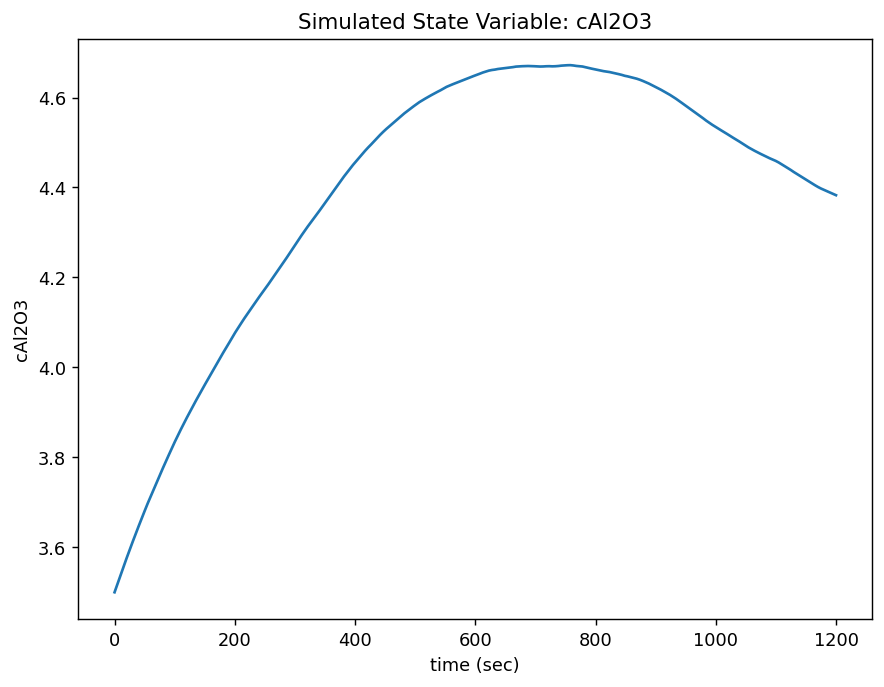

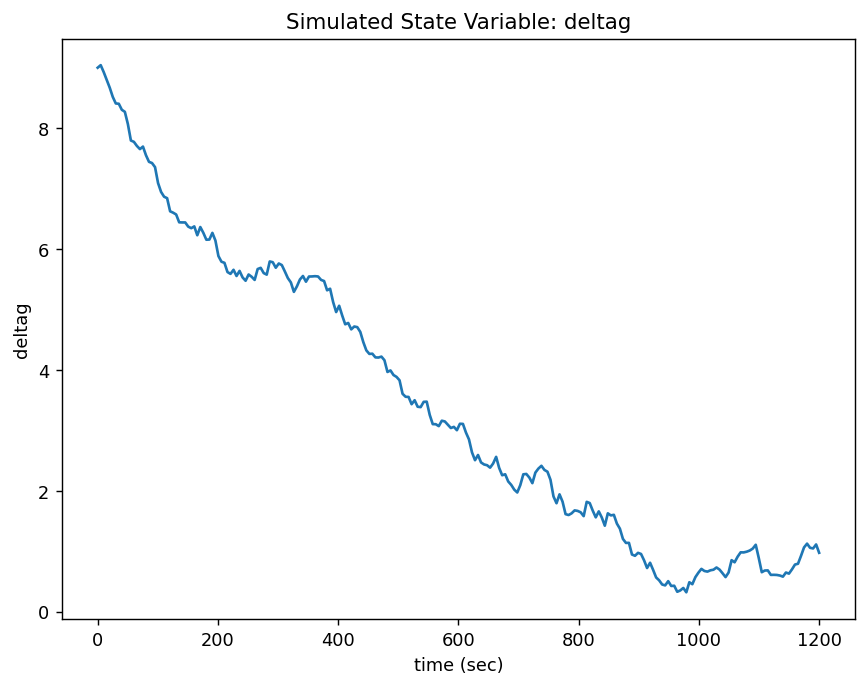

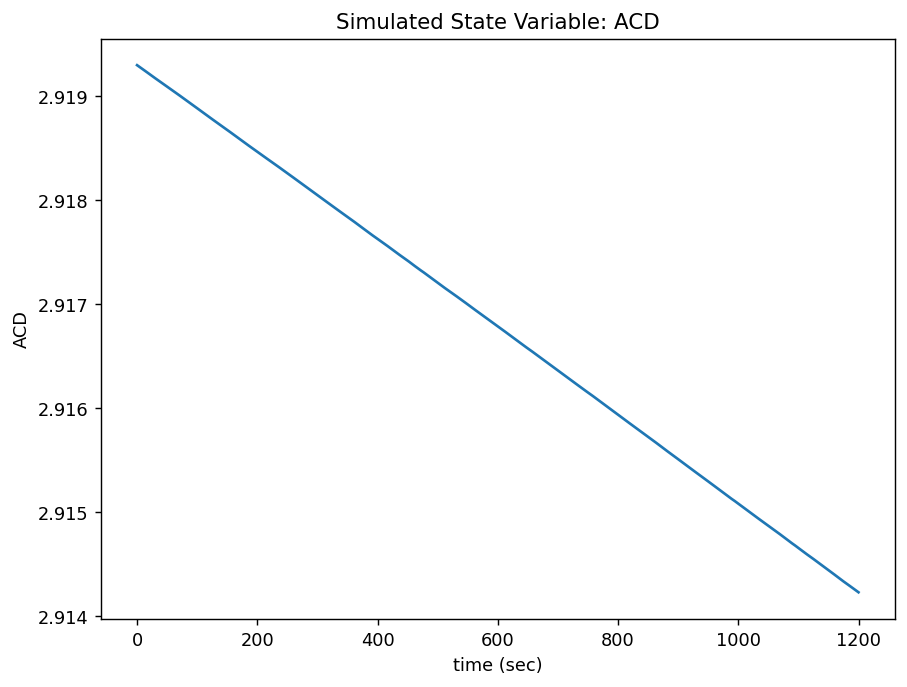

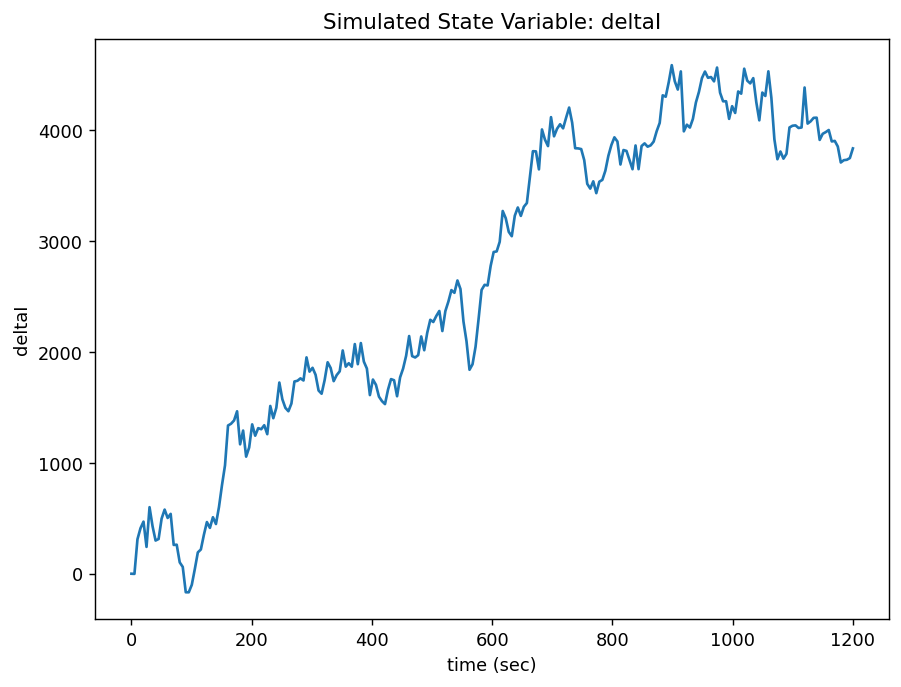

In [45]:
# now lets use the model to generate a simulation that could then be used to test the UKF over multiple steps
from Refactor.Simulation import sim_nofeeding, plot_xsim, sim_observation, plot_zsim
x, u = sim_nofeed(5, 240, bbcell, alumina4state, u0, x0, plotresult=True, statenoise=True)

### Mainfestations of model inconsistency:
### 1) cAl2O3 increases rapidly to "consume" the initial delta_g, but amplified cf decay of delta_g
### 2) Simulated delta_I random walk results in significant deviation of total current from nominal 

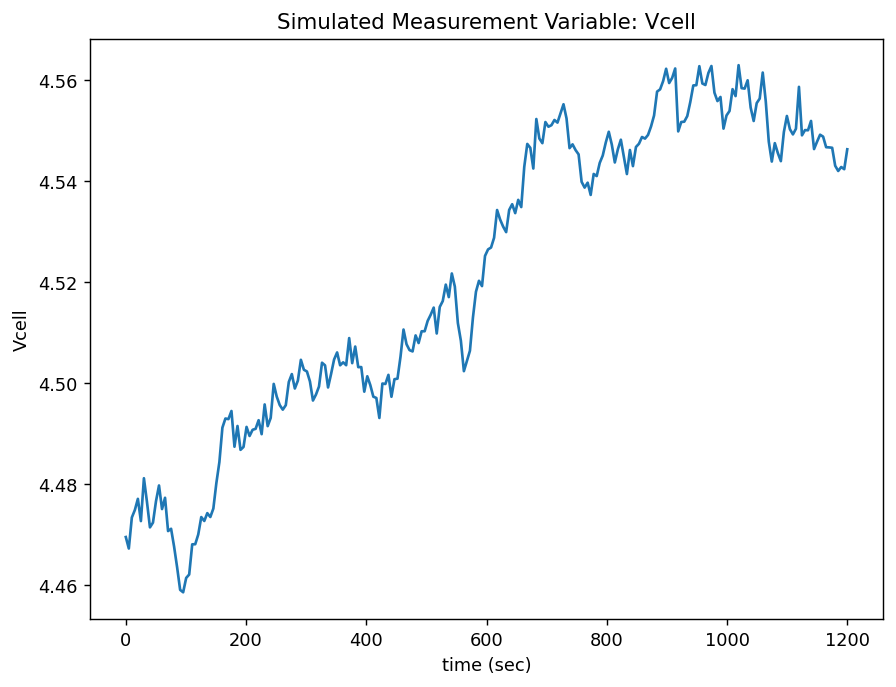

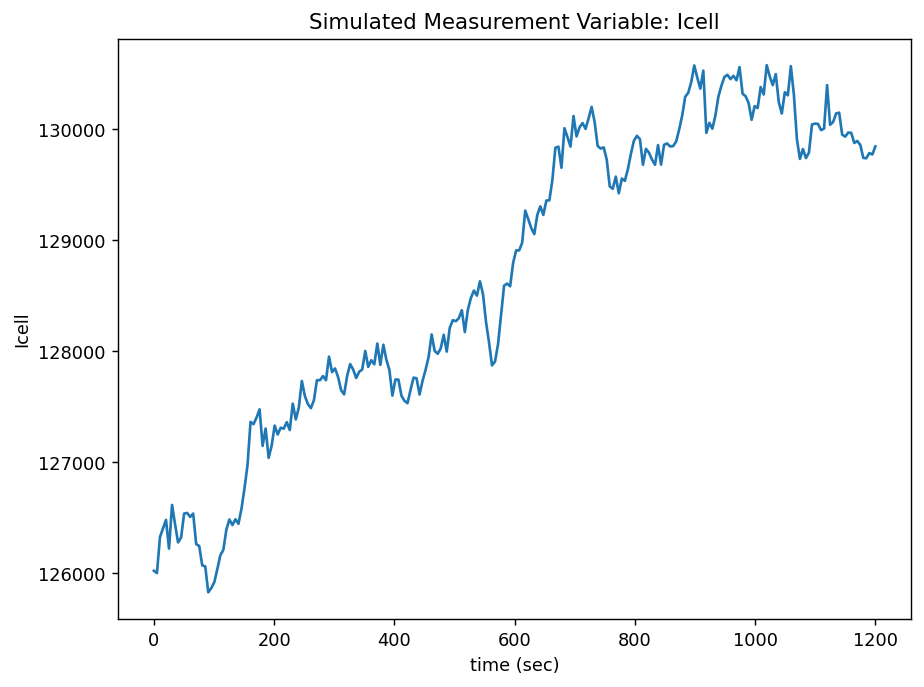

In [46]:
# generate and plot the resulting simulation 
z = sim_observation(5, x, u, bbcell, alumina4state, plotresult=True)

### voltage trend almost looks as expected, but actually on the wrong side of the alumina vs resistance curve